In [1]:
import os
import itertools
import json
import tqdm
import yaml
from enum import Enum

import torch
import numpy as np
import matplotlib.pyplot as plt

from omegaconf import OmegaConf
from pathlib import Path
from tqdm.auto import tqdm
os.makedirs('./learning_curves', exist_ok=True)

base_results_path = os.path.join(os.sep, "mnt", "stud", "home", "ynagel", "dal-toolbox", "results", "al_baselines")

/mnt/stud/home/ynagel/dal-toolbox/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Specifying enums

class Dataset(Enum):
    CIFAR10 = "CIFAR10"
    CIFAR100 = "CIFAR100"
    SVHN = "SVHN"

class Model(Enum):
    ResNet18 = "resnet18"
    Linear = "linear"

class Strategy(Enum):
    Random = "random"
    Entropy = "entropy"
    BADGE = "badge"
    CoreSet = "coreset"
    TypiClust = "typiclust"
    ProbCover = "probcover"

In [3]:
def load_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def load_results(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
    exp_json = path / 'results.json'
    results = load_json(exp_json)
    return results

def load_args(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
    exp_cfg = path / '.hydra' / 'config.yaml'
    cfg =  OmegaConf.load(exp_cfg)
    return cfg

def load_checkpoint(path, final=True):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
    if final:
        exp_pth = path / 'model_final.pth'
    else:
        exp_pth = path / 'checkpoint.pth'
    checkpoint = torch.load(exp_pth)
    return checkpoint

def get_experiments(result_path, glob_pattern, train_results=False):
    # Aggregate results over multiple glob pattern such as seeds
    experiments = []
    for exp_path in result_path.glob(glob_pattern):
        d = load_results(exp_path)
        experiments.append(d)
    assert len(experiments) != 0, f'No experiments found for {result_path}.'
    return experiments

def create_results_path(dataset, model, strategy, budget, path=base_results_path):
    return Path(os.path.join(path, dataset, model, strategy, f"budget_{budget}"))

def create_extended_results_path(dataset,  model, al_strategy, init_strategy, n_init, acq_size, n_acq, suffix=""): # Mainly for linear mdoels
    return Path(os.path.join(base_results_path, f"{dataset}", f"{model}", f"{al_strategy}_{init_strategy}{f'_{suffix}' if suffix != '' else ''}", f"N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{n_acq}"))


# Test loading results
path = create_results_path(Dataset.CIFAR10.value, Model.ResNet18.value, Strategy.Random.value, 1000)
exp_results = get_experiments(path, 'seed1')
print(exp_results[0].keys())

path = create_extended_results_path(Dataset.CIFAR10.value, Model.Linear.value, Strategy.TypiClust.value, Strategy.Random.value, 10, 10, 49)
exp_results = get_experiments(path, 'seed1')
print(exp_results[0].keys())

dict_keys(['cycle0', 'cycle1', 'cycle2', 'cycle3', 'cycle4', 'cycle5', 'cycle6', 'cycle7', 'cycle8', 'cycle9'])
dict_keys(['cycle0', 'cycle1', 'cycle2', 'cycle3', 'cycle4', 'cycle5', 'cycle6', 'cycle7', 'cycle8', 'cycle9', 'cycle10', 'cycle11', 'cycle12', 'cycle13', 'cycle14', 'cycle15', 'cycle16', 'cycle17', 'cycle18', 'cycle19', 'cycle20', 'cycle21', 'cycle22', 'cycle23', 'cycle24', 'cycle25', 'cycle26', 'cycle27', 'cycle28', 'cycle29', 'cycle30', 'cycle31', 'cycle32', 'cycle33', 'cycle34', 'cycle35', 'cycle36', 'cycle37', 'cycle38', 'cycle39', 'cycle40', 'cycle41', 'cycle42', 'cycle43', 'cycle44', 'cycle45', 'cycle46', 'cycle47', 'cycle48', 'cycle49'])


In [4]:
def generate_learning_curves(experiments):
    learning_curves = {}
    for exp_name, path in experiments.items():
        seed_results = get_experiments(Path(path), glob_pattern='seed*')
    
        seed_accuracies = []
        seed_num_labeled = []
        for results in seed_results:
            seed_accuracies.append([val['test_stats']['accuracy'] for key, val in results.items()])
            seed_num_labeled.append([val['n_labeled_samples'] for key, val in results.items()])
        metrics = {
            'acc': np.mean(seed_accuracies, axis=0), 
            'acc_std': np.std(seed_accuracies, axis=0), 
            'num_labeled': np.mean(seed_num_labeled, axis=0)
        }
        learning_curves[exp_name] = metrics
    return learning_curves

def plot_learning_curves(learning_curves, plot_std=True, title="", save=True, savePath=None, xlim=None, plot_until=None):
    plt.figure(figsize=(7, 5))
    for exp_name, metrics in learning_curves.items():
        if plot_until:
            until = np.where(metrics['num_labeled']==plot_until)[0][0] + 1
            plt.plot(metrics['num_labeled'][:until], metrics['acc'][:until], '-o', label=exp_name)
            if plot_std:
                plt.fill_between(metrics['num_labeled'][:until], metrics['acc'][:until] - metrics['acc_std'][:until], metrics['acc'][:until] + metrics['acc_std'][:until], alpha=.5)
        else:
            plt.plot(metrics['num_labeled'], metrics['acc'], '-o', label=exp_name)
            if plot_std:
                plt.fill_between(metrics['num_labeled'], metrics['acc'] - metrics['acc_std'], metrics['acc'] + metrics['acc_std'], alpha=.5)
    plt.title(title)
    plt.xlabel('Number of Annotations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()

    if xlim is not None:
        plt.xlim(xlim)

    if save:
        assert savePath is not None, "savePath has to be specified when saving image"
        plt.savefig(savePath)

    plt.show()

## ResNet18 Experiments

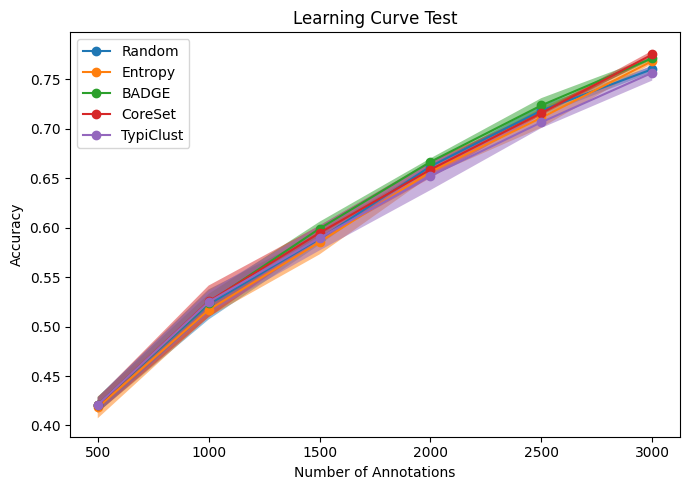

al_cycle:
  n_init: 500
  acq_size: 500
  n_acq: 9
  cold_start: true
random_seed: 1
dataset_path: /mnt/stud/home/ynagel/data
val_interval: 25
output_dir: /mnt/stud/home/ynagel/dal-toolbox/results/al_baselines/CIFAR10/resnet18/random/budget_5000/seed1/
model:
  name: resnet18_deterministic
  num_epochs: 200
  train_batch_size: 64
  predict_batch_size: 256
  optimizer:
    lr: 0.001
    weight_decay: 0.05
    momentum: 0.9
dataset:
  name: CIFAR10
al_strategy:
  name: random



In [5]:
budget = 5000
dataset = Dataset.CIFAR10.value
model = Model.ResNet18.value

experiments = {
    "Random": create_results_path(dataset ,model, Strategy.Random.value, budget),
    "Entropy": create_results_path(dataset, model, Strategy.Entropy.value, budget),
    "BADGE": create_results_path(dataset, model, Strategy.BADGE.value, budget),
    "CoreSet": create_results_path(dataset, model, Strategy.CoreSet.value, budget),
    "TypiClust": create_results_path(dataset, model, Strategy.TypiClust.value, budget),
}

plot_learning_curves(generate_learning_curves(experiments), title = "Learning Curve Test", save=False, plot_until=3000)
print(OmegaConf.to_yaml(load_args(Path(experiments['Random']) / 'seed1')))

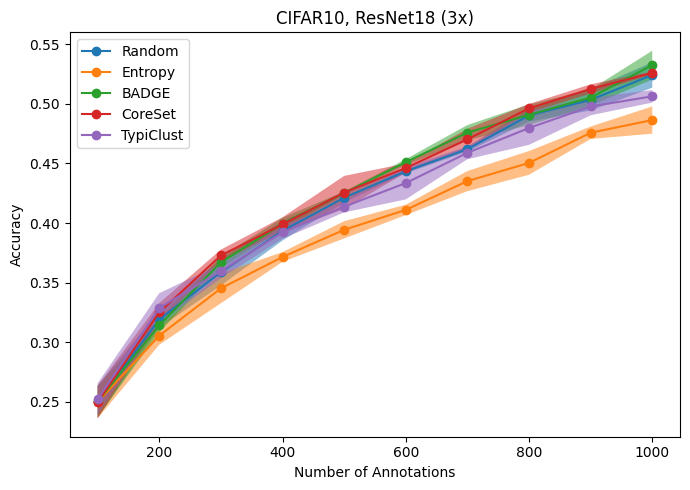

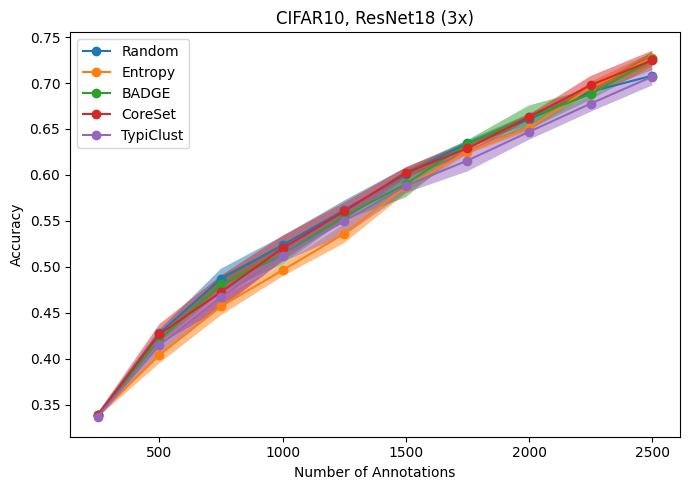

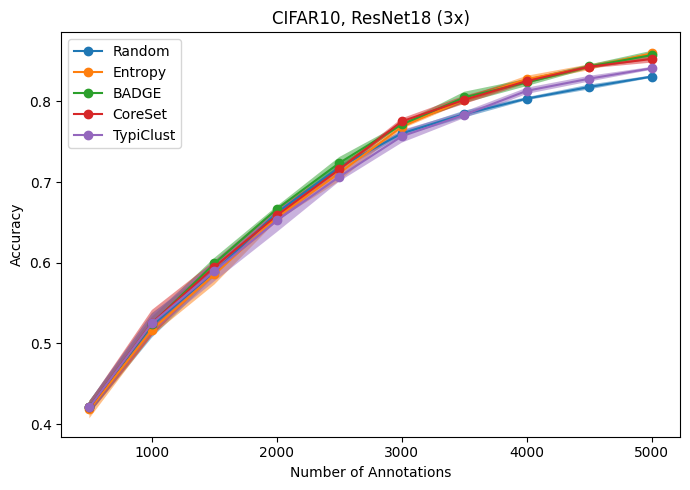

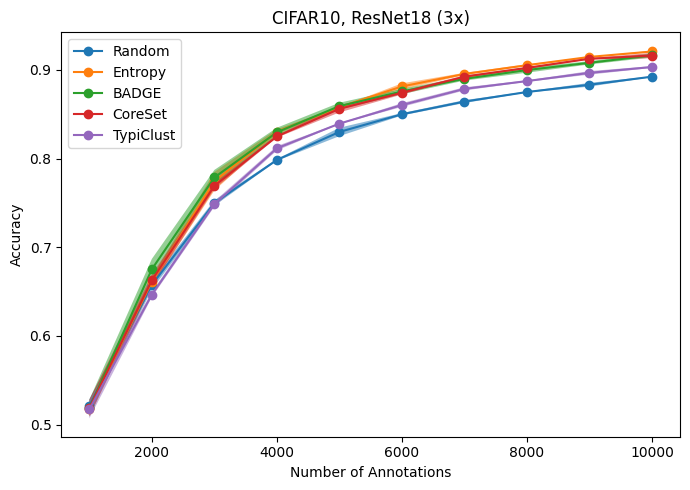

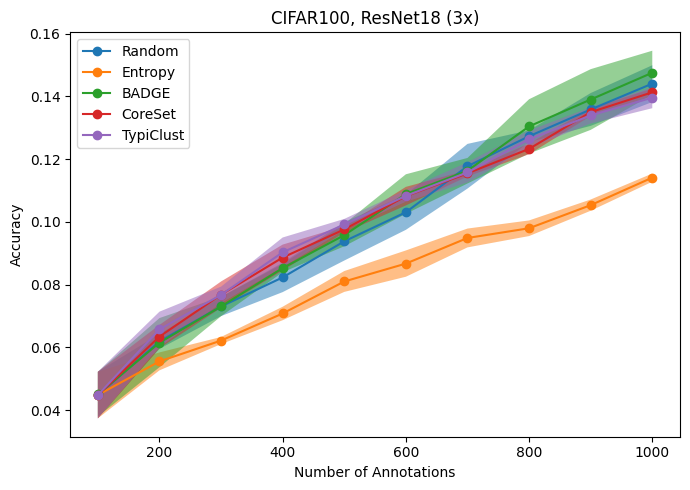

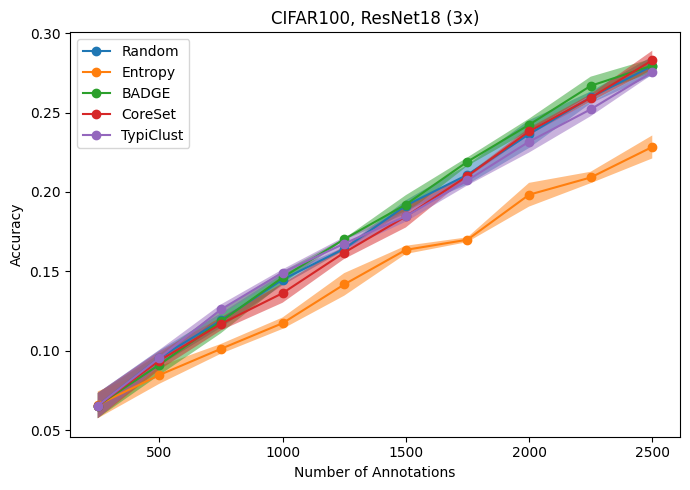

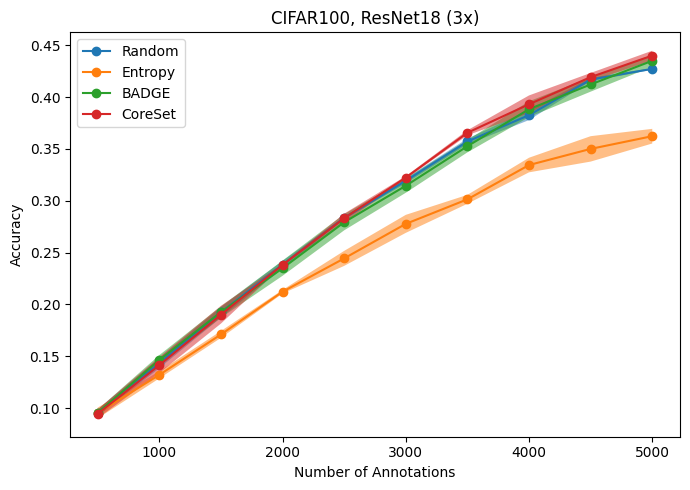

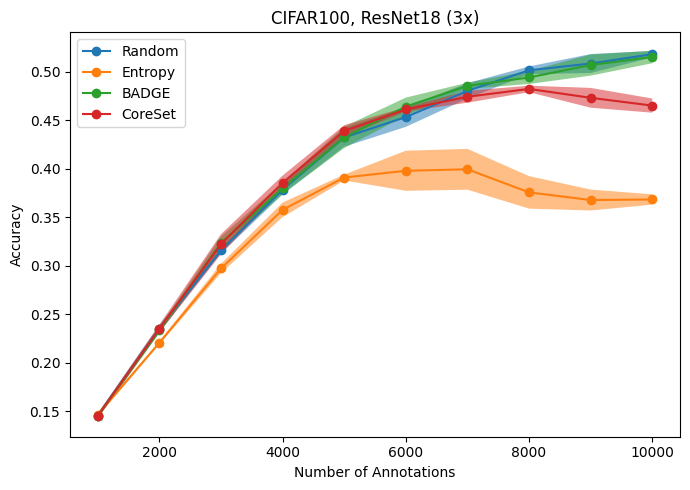

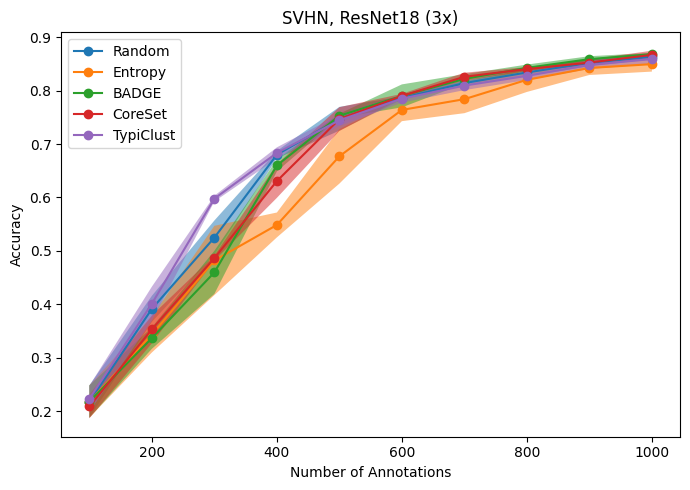

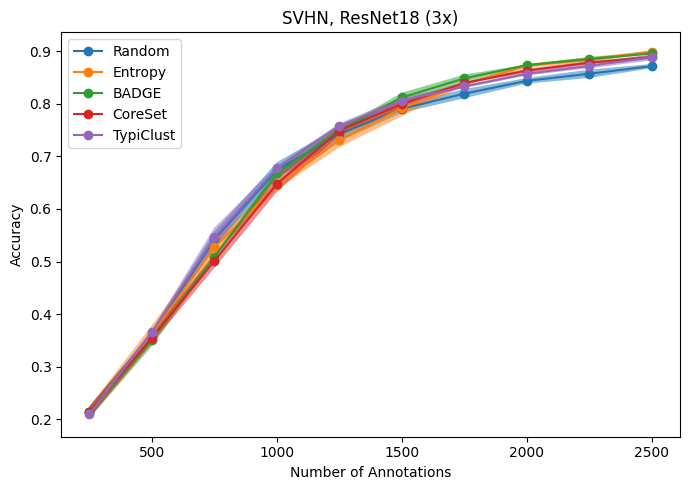

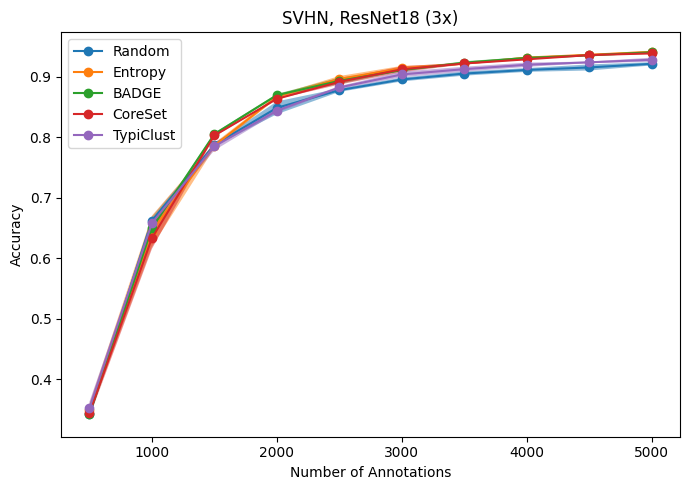

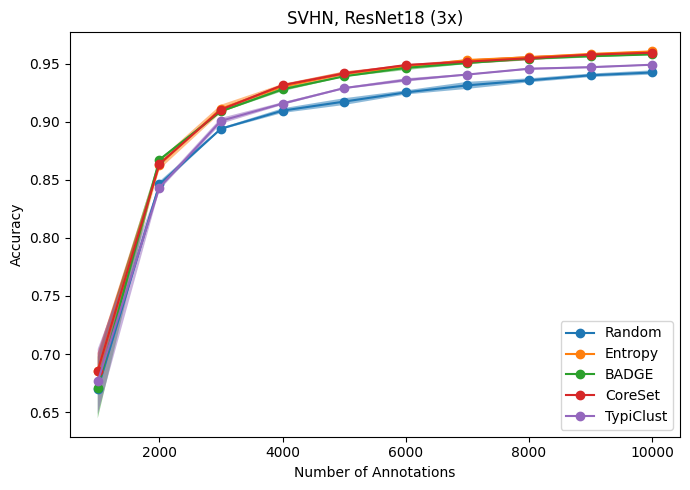

In [6]:
# Generating all baseline results (Strategies are kept on the same plot)

datasets = [Dataset.CIFAR10, Dataset.CIFAR100, Dataset.SVHN]
models = [Model.ResNet18]
budgets = [1000, 2500, 5000, 10000]

lp = itertools.product(datasets, models, budgets)

for dataset, model, budget in lp:
    dataset_name = dataset.name
    model_name = model.name

    dataset = dataset.value
    model = model.value
    
    experiments = {
        "Random": create_results_path(dataset, model, Strategy.Random.value, budget),
        "Entropy": create_results_path(dataset, model, Strategy.Entropy.value, budget),
        "BADGE": create_results_path(dataset, model, Strategy.BADGE.value, budget),
        "CoreSet": create_results_path(dataset, model, Strategy.CoreSet.value, budget),
        "TypiClust": create_results_path(dataset, model, Strategy.TypiClust.value, budget),
    }

    if dataset == "CIFAR100" and budget >= 5000:
        del experiments["TypiClust"]


    savePath = Path(os.path.join("learning_curves", dataset, model, f"budet{budget}.png"))
    os.makedirs(os.path.join("learning_curves", dataset, model), exist_ok=True)

    try:
        plot_learning_curves(generate_learning_curves(experiments), title = f"{dataset_name}, {model_name} (3x)", save=True, savePath=savePath)
    except FileNotFoundError as e:
        print(e)                         

## Linear Experiments

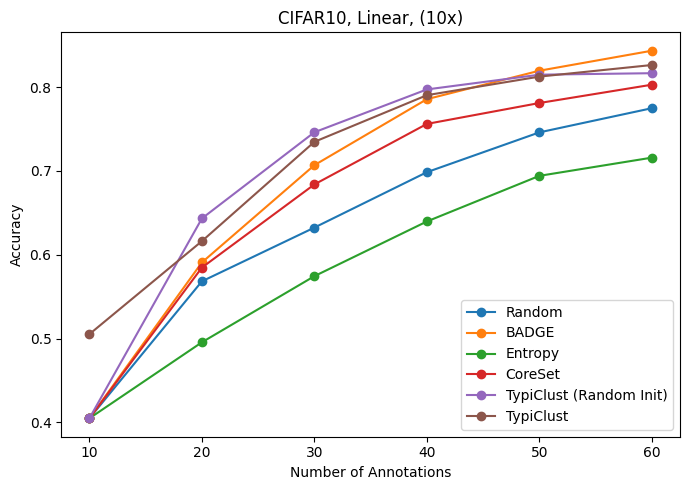

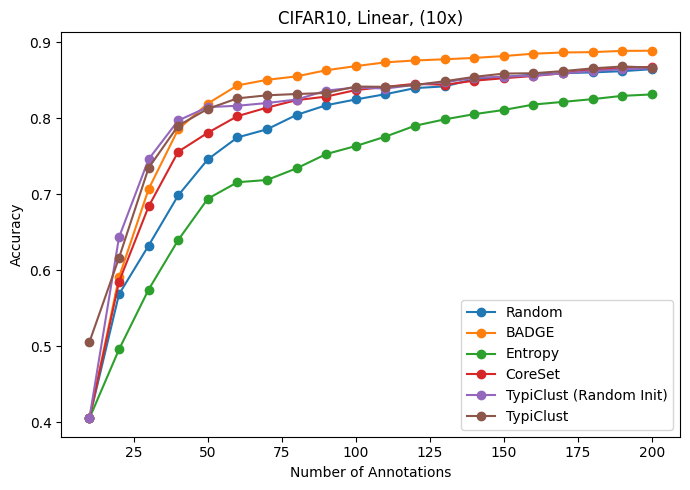

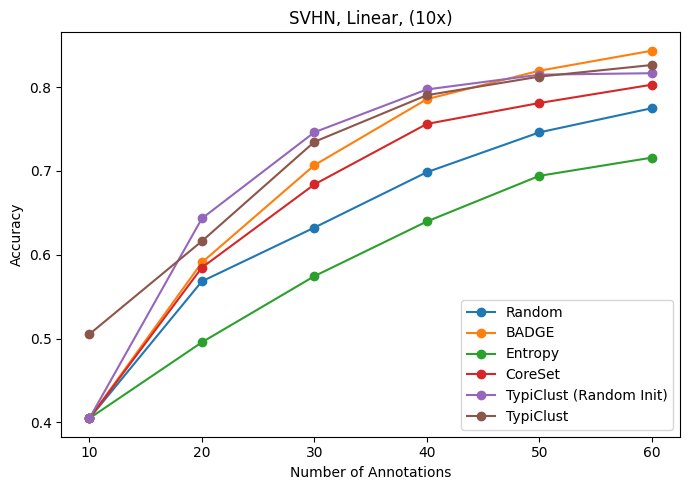

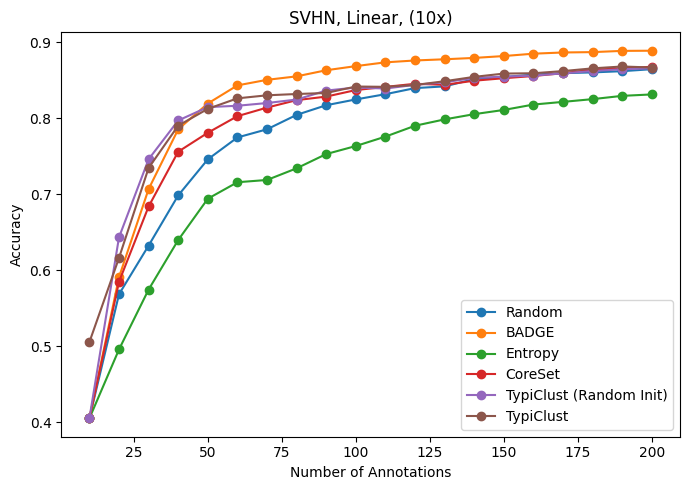

In [6]:
datasets = [Dataset.CIFAR10, Dataset.SVHN]
models = [Model.Linear]
budgets = [60, 200]

lp = itertools.product(datasets, models, budgets)

for dataset, model, budget in lp:
    dataset_name = dataset.name
    model_name = model.name

    dataset = dataset.value
    model = model.value

    experiments = {
        "Random": create_extended_results_path(Dataset.CIFAR10.value, Model.Linear.value, Strategy.Random.value, Strategy.Random.value, 10, 10, 49),
        "BADGE": create_extended_results_path(Dataset.CIFAR10.value, Model.Linear.value, Strategy.BADGE.value, Strategy.Random.value, 10, 10, 49),
        "Entropy": create_extended_results_path(Dataset.CIFAR10.value, Model.Linear.value, Strategy.Entropy.value, Strategy.Random.value, 10, 10, 49),
        "CoreSet": create_extended_results_path(Dataset.CIFAR10.value, Model.Linear.value, Strategy.CoreSet.value, Strategy.Random.value, 10, 10, 49),
        "TypiClust (Random Init)": create_extended_results_path(Dataset.CIFAR10.value, Model.Linear.value, Strategy.TypiClust.value, Strategy.Random.value, 10, 10, 49),
        "TypiClust": create_extended_results_path(Dataset.CIFAR10.value, Model.Linear.value, Strategy.TypiClust.value, Strategy.TypiClust.value, 10, 10, 49),
    }

    savePath = Path(os.path.join("learning_curves", dataset, model, f"budet{budget}.png"))
    os.makedirs(os.path.join("learning_curves", dataset, model), exist_ok=True)

    try:
        plot_learning_curves(generate_learning_curves(experiments), title = f"{dataset_name}, {model_name}, (10x)", save=True, savePath=savePath, plot_std=False, plot_until=budget)
    except FileNotFoundError as e:
        print(e)